## Important notes: 
Before running this code, please ensures that you have set up the following directory structure:
```
/root
  |-- distilbert_classifier.ipynb
  |-- /dataset
    |-- train.csv
    |-- test.csv
```

In [1]:
# Import common libraries.
import numpy as np
import pandas as pd

from sklearn import metrics

from tqdm import tqdm

import matplotlib.pyplot as plt

## Loading Dataset
Thank you Daren for preparing the dataset!

In [2]:
# Load the data from the dataset
original_training_df = pd.read_csv("./dataset/train.csv")
original_testing_df = pd.read_csv("./dataset/test.csv")

original_training_df.shape, original_testing_df.shape

((34040, 5), (8510, 5))

### (Optional) Studying the dataset
Maximum tokenized sentence length supported for `DistilBERT` is `512` words. We can make the tokenizer truncate automatically for us, but it would be nice to truncate even more to help speed up the training process. Daren has also provided us with statistics of the dataset such as min, max and mean lengths, but let's plot a histogram and also identify the quartiles to find a safer boundary.

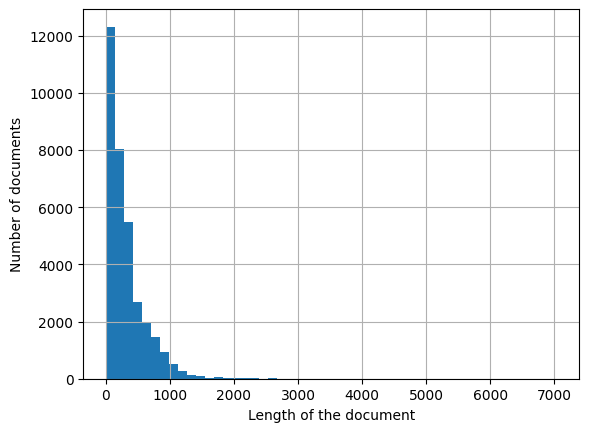

array([1.000e+00, 7.100e+01, 2.180e+02, 4.150e+02, 7.033e+03])

In [3]:
document_len = [len(document.split()) for document in original_training_df["Document"]]
pd.Series(document_len).hist(bins=50)
# plt.xlim([0, 1000])
plt.xlabel('Length of the document')
plt.ylabel('Number of documents')
plt.show()

np.quantile(document_len, [0, 0.25, 0.5, 0.75, 1])

Unfortunately, it seems that quite a bit of documents (almost a whole quartile) have lengths that lie beyond the maximum sequence length.

## Pre-processing dataset

### Splitting the dataset
We will split the dataset into 85/15 (training/validation) which will yield a validation set of 5,000+ sampels.

In [3]:
# Splitting dataset into training/validation/test set with 70/15/15 ratio.
from sklearn.model_selection import train_test_split

# Splitting to training/validation set.
X_train, X_val, Y_train, Y_val = train_test_split(original_training_df["Document"], original_training_df["Label"], 
                                                                 test_size=0.15,
                                                                 random_state=4248,
                                                                 stratify=original_training_df["Label"])

# Also load prepare the test set.
# Random sample to reduce testing size
# original_testing_df = original_testing_df.sample(frac=0.5, random_state=4248)
X_test = original_testing_df["Document"]
Y_test = original_testing_df["Label"]

print("Size of training set: {}".format(len(X_train)))
print("Size of validation set: {}".format(len(X_val)))
print("Size of test set: {}".format(len(X_test)))

Size of training set: 28934
Size of validation set: 5106
Size of test set: 8510


### DistilBERT Tokenizer
We will be using `DistilBert` model, load a suitable tokenizer from Hugging Face's `transformers` library.

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", truncation=True, do_lower_case=True, use_fast=True)  # remove use_fast argument if it throws an error

Trying out the tokenizer to understand how it works:

In [6]:
sample_document = original_testing_df["Document"][0]
print(sample_document)
tokenizer(sample_document)

WASHINGTON (Reuters) - U.S. Secretary of State Rex Tillerson will travel to the Philippines, Thailand and Malaysia Aug. 5 to Aug. 9, the State Department said on Tuesday. Tillerson will participate in meetings of diplomats of the Association of Southeast Asian Nations in Manila, and discuss “denuclearization of the Korean Peninsula, maritime security, and counterterrorism,” the State Department said. In Thailand, Tillerson will pay his respects to the late King Bhumibol Adulyadej, who died in 2016, and discuss the U.S.-Thai relationship with officials there. In Malaysia, he will discuss bilateral relations with officials. “Secretary Tillerson’s travel reaffirms the Administration’s commitment to further broaden and enhance U.S. economic and security interests in the Asia-Pacific region,” the State Department said. 


{'input_ids': [101, 2899, 1006, 26665, 1007, 1011, 1057, 1012, 1055, 1012, 3187, 1997, 2110, 10151, 6229, 18617, 2097, 3604, 2000, 1996, 5137, 1010, 6504, 1998, 6027, 15476, 1012, 1019, 2000, 15476, 1012, 1023, 1010, 1996, 2110, 2533, 2056, 2006, 9857, 1012, 6229, 18617, 2097, 5589, 1999, 6295, 1997, 23473, 1997, 1996, 2523, 1997, 4643, 4004, 3741, 1999, 9011, 1010, 1998, 6848, 1523, 7939, 14194, 19738, 26910, 1997, 1996, 4759, 6000, 1010, 7803, 3036, 1010, 1998, 4675, 3334, 29165, 2964, 1010, 1524, 1996, 2110, 2533, 2056, 1012, 1999, 6504, 1010, 6229, 18617, 2097, 3477, 2010, 17475, 2000, 1996, 2397, 2332, 1038, 28600, 12322, 4747, 4748, 5313, 25152, 20518, 1010, 2040, 2351, 1999, 2355, 1010, 1998, 6848, 1996, 1057, 1012, 1055, 1012, 1011, 7273, 3276, 2007, 4584, 2045, 1012, 1999, 6027, 1010, 2002, 2097, 6848, 17758, 4262, 2007, 4584, 1012, 1523, 3187, 6229, 18617, 1521, 1055, 3604, 2128, 10354, 27972, 2015, 1996, 3447, 1521, 1055, 8426, 2000, 2582, 5041, 2368, 1998, 11598, 1057, 1012

Tokenize the training and testing set:

In [5]:
# Dataset exploration reveals that significant portion of documents have lengths exceeding the maximum sequence length.
# Should truncate as less as possible, but adjust MAX_LENGTH if needed.
MAX_LENGTH = 512

# Tokenizing the training set.
training_tokens = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True
)

# Tokenizing the validation set.
validation_tokens = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True
)

# Tokenizing the test set.
test_tokens = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True
)

Now the standard procedure, convert them into tensors, wrap them in `TensorDataset` and define the data loaders to be used for training:

Recall that our tokenizer will return a dictionary with `input_ids` and `attention_mask`.

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# Training and validation set.
X_train_seq = torch.tensor(training_tokens['input_ids'])
X_train_mask = torch.tensor(training_tokens['attention_mask'])
Y_train = torch.tensor(Y_train.tolist())
print(X_train.shape, Y_train.shape)
dataset_train = TensorDataset(X_train_seq, X_train_mask, Y_train)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

X_val_seq = torch.tensor(validation_tokens['input_ids'])
X_val_mask = torch.tensor(validation_tokens['attention_mask'])
Y_val = torch.tensor(Y_val.tolist())
print(X_val.shape, Y_val.shape)
dataset_val = TensorDataset(X_val_seq, X_val_mask, Y_val)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# Test set for evaluation.
X_test_seq = torch.tensor(test_tokens['input_ids'])
X_test_mask = torch.tensor(test_tokens['attention_mask'])
Y_test = torch.tensor(Y_test.tolist())
print(X_test.shape, Y_test.shape)
dataset_test = TensorDataset(X_test_seq, X_test_mask, Y_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

(28934,) torch.Size([28934])
(5106,) torch.Size([5106])
(8510,) torch.Size([8510])


## Setting up device for GPU

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

print("Device is set to: {}".format(device))

Device is set to: cuda


## Setting up the DistilBERT model
Code partially adapted from Prof. Chris's [MLP tutorial](https://github.com/chrisvdweth/nus-cs4248x/blob/master/3-neural-nlp/Section%201.1%20-%20Basic%20MLP.ipynb).

### DistilBert model architecture

Diagram and detailed explanation to be included in the report.

In [8]:
from transformers import DistilBertModel
import torch.nn as nn

class DistilBERTClassifier(nn.Module):
    
    def __init__(self):
        super(DistilBERTClassifier, self).__init__()
        self.distil_bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.out = nn.Linear(512, 2)  # Output layer
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        bert_output = self.distil_bert(input_ids=input_ids, attention_mask=attention_mask)
        # print(bert_output)
        # Note that DistilBERT has no pooler layer (see transformers' BaseModelOutput documentation).
        hidden_state = bert_output[0]
        # print(hidden_state)
        pooler = hidden_state[:, 0]
        # print(pooler)

        x = self.fc1(pooler)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        log_probs = self.log_softmax(x)
        return log_probs

Create model and move to device. Also define `optimizer` (AdamW), `criterion` (loss function) and set the number of epochs.

In [9]:
# Hyperparameters
learning_rate = 1e-5
num_epochs = 3

lun_classifier = DistilBERTClassifier().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(lun_classifier.parameters(), lr=learning_rate)

### Training and evaluation functions

Training function to wrap training process:

In [10]:
def train(model, loader_train, optimizer, criterion):

    model.train()

    total_loss = 0.0

    with tqdm(total=len(loader_train)) as pbar:

        # Loop over each batch in the data loader
        for batch in loader_train:

            X_batch_seq, X_batch_mask, Y_batch = batch
            
            # Move data to device
            X_batch_seq, X_batch_mask, Y_batch = X_batch_seq.to(device), X_batch_mask.to(device), Y_batch.to(device)

            # Push batch through network to get log probabilities for each sample in batch
            log_probs = model(X_batch_seq, X_batch_mask)                

            # Calculate loss
            loss = criterion(log_probs, Y_batch)
            total_loss = total_loss + loss.item()

            ### PyTorch Magic! ###
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_probs = log_probs.detach().cpu().numpy()

            pbar.update(1)
        
    avg_loss = total_loss / len(loader_train)
    return avg_loss

Evaluation function with validation set:

In [11]:
def evaluate(model, loader_val):

    model.eval()

    total_loss = 0.0

    with tqdm(total=len(loader_val)) as pbar:
        
        # Loop over each batch in the data loader
        for batch in loader_val:

            X_batch_seq, X_batch_mask, Y_batch = batch
            
            # Move data to device
            X_batch_seq, X_batch_mask, Y_batch = X_batch_seq.to(device), X_batch_mask.to(device), Y_batch.to(device)

            with torch.no_grad():
                # Push batch through network to get log probabilities for each sample in batch
                log_probs = model(X_batch_seq, X_batch_mask)                
            
                # Compute validation loss between actual and predicted values
                loss = criterion(log_probs, Y_batch)
                total_loss = total_loss + loss.item()

                log_probs = log_probs.detach().cpu().numpy()

            pbar.update(1)
        
    # Set model back to train mode.
    model.train()

    avg_loss = total_loss / len(loader_val)
    return avg_loss

## Training the DistilBERT LUN classifier

In [14]:
# Training and evaluating the predictions.

best_val_loss = float('inf')
training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))

    training_loss = train(lun_classifier, loader_train, optimizer, criterion)
    validation_loss = evaluate(lun_classifier, loader_val)
    
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        torch.save(lun_classifier.state_dict(), 'DistilBERT_LUN_weights.pt')
    
    training_losses.append(training_loss)
    validation_losses.append(validation_loss)

    print(f'\nTraining Loss: {training_loss:.3f}')
    print(f'Validation Loss: {validation_loss:.3f}')


 Epoch 1 / 3


100%|██████████| 160/160 [00:46<00:00,  3.48it/s]



Training Loss: 0.166
Validation Loss: 0.125

 Epoch 2 / 3


100%|██████████| 160/160 [00:45<00:00,  3.48it/s]



Training Loss: 0.116
Validation Loss: 0.127

 Epoch 3 / 3


100%|██████████| 160/160 [00:45<00:00,  3.48it/s]


Training Loss: 0.096
Validation Loss: 0.130


In [14]:
def predict_and_eval(model, loader):

    model.eval()
    
    Y_pred, Y_test = [], []

    with tqdm(total=len(loader)) as pbar:
        
        # Loop over each batch in the data loader
        for batch in loader_val:

            X_batch_seq, X_batch_mask, Y_batch = batch
            
            # Move data to device
            X_batch_seq, X_batch_mask, Y_batch = X_batch_seq.to(device), X_batch_mask.to(device), Y_batch.to(device)

            # Push batch through network to get log probabilities for each sample in batch
            log_probs = model(X_batch_seq, X_batch_mask)                
            
            # The predicted labels are the index of the higest log probability (for each sample)
            Y_batch_pred = torch.argmax(log_probs, dim=1)

            # Add predictions and ground truth for current batch
            Y_test += list(Y_batch.detach().cpu().numpy())
            Y_pred += list(Y_batch_pred.detach().cpu().numpy())

            pbar.update(1)

    model.train()            
            
    # Return the f1 score as the output result
    return Y_pred, Y_test

In [15]:
from sklearn.metrics import classification_report

path = 'DistilBERT_LUN_weights.pt'
lun_classifier.load_state_dict(torch.load(path))

# X_test_seq, X_test_mask = X_test_seq.to(device), X_test_mask.to(device)

Y_pred, Y_test = predict_and_eval(lun_classifier, loader_test)

print(classification_report(Y_test, Y_pred))

 60%|██████    | 160/266 [00:44<00:29,  3.58it/s]

              precision    recall  f1-score   support

           0       0.96      0.85      0.91      2028
           1       0.91      0.98      0.94      3078

    accuracy                           0.93      5106
   macro avg       0.94      0.92      0.92      5106
weighted avg       0.93      0.93      0.93      5106

